In [3]:
# Install Kaggle API and authenticate


# Import necessary libraries
import pandas as pd
from glob import glob
import shutil
import os

# Load metadata
metadata_path = "content/HAM10000_metadata.csv"
df = pd.read_csv(metadata_path)

# Map lesion types to readable names
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
df['cell_type'] = df['dx'].map(lesion_type_dict)

# List the contents of the image directories
image_folders = [
    'content/HAM10000_images_part_1',
    'content/HAM10000_images_part_2',
    'content/ham10000_images_part_1',
    'content/ham10000_images_part_2'
]

# Get all image paths from the relevant directories
image_paths = []
for folder in image_folders:
    if os.path.exists(folder):
        image_paths.extend(glob(os.path.join(folder, '*.jpg')))

# Create a dictionary that maps image ids to their paths
imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in image_paths
}

# Add the image paths to the DataFrame
df['image_path'] = df['image_id'].map(imageid_path_dict.get)

# Function to check the mapping of images to their classes
def verify_mapping_and_separate_classes(df):
    # Check the mapping for any None values
    unmapped_images = df[df['image_path'].isna()]
    if not unmapped_images.empty:
        print("Unmapped images:")
        print(unmapped_images)
    else:
        print("All images are mapped correctly.")

    # Create directories for each class
    output_dir = "" \
    "" \
    "content/skin_cancer_images"
    os.makedirs(output_dir, exist_ok=True)

    # Create a subfolder for each class
    for lesion in df['cell_type'].unique():
        class_folder = os.path.join(output_dir, lesion)
        os.makedirs(class_folder, exist_ok=True)

    # Move images to respective class folders
    for index, row in df.iterrows():
        image_path = row['image_path']
        if pd.notna(image_path):
            class_folder = os.path.join(output_dir, row['cell_type'])
            shutil.copy(image_path, class_folder)

    print(f"Images are separated into respective folders under {output_dir}.")

# Call the function to verify mapping and separate the images
verify_mapping_and_separate_classes(df)

# Display data distribution (number of images per class)
class_counts = df['cell_type'].value_counts()
print("Data distribution (Number of images per class):")
print(class_counts)

# Save the counts in a text file
class_counts.to_csv('content/class_counts.csv', header=True)



All images are mapped correctly.
Images are separated into respective folders under content/skin_cancer_images.
Data distribution (Number of images per class):
cell_type
Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: count, dtype: int64


Using device: mps
Epoch [1/414], Step [1/8], D Loss: 0.6930, G Loss: 0.4459
Epoch [2/414], Step [1/8], D Loss: 2.7653, G Loss: 0.8679
Epoch [3/414], Step [1/8], D Loss: 0.7319, G Loss: 0.9148
Epoch [4/414], Step [1/8], D Loss: 0.4420, G Loss: 1.5612
Epoch [5/414], Step [1/8], D Loss: 0.7031, G Loss: 2.2902
Epoch [6/414], Step [1/8], D Loss: 0.6583, G Loss: 0.9045
Epoch [7/414], Step [1/8], D Loss: 0.5893, G Loss: 1.3046
Epoch [8/414], Step [1/8], D Loss: 0.4478, G Loss: 2.1960
Epoch [9/414], Step [1/8], D Loss: 0.5040, G Loss: 1.0236
Epoch [10/414], Step [1/8], D Loss: 0.8246, G Loss: 0.7918
Epoch [11/414], Step [1/8], D Loss: 0.6635, G Loss: 2.3234
Epoch [12/414], Step [1/8], D Loss: 0.6444, G Loss: 1.1775
Epoch [13/414], Step [1/8], D Loss: 0.5925, G Loss: 0.8322
Epoch [14/414], Step [1/8], D Loss: 0.5752, G Loss: 1.6416
Epoch [15/414], Step [1/8], D Loss: 0.6052, G Loss: 0.9989
Epoch [16/414], Step [1/8], D Loss: 0.6430, G Loss: 0.6246
Epoch [17/414], Step [1/8], D Loss: 0.9016, G L

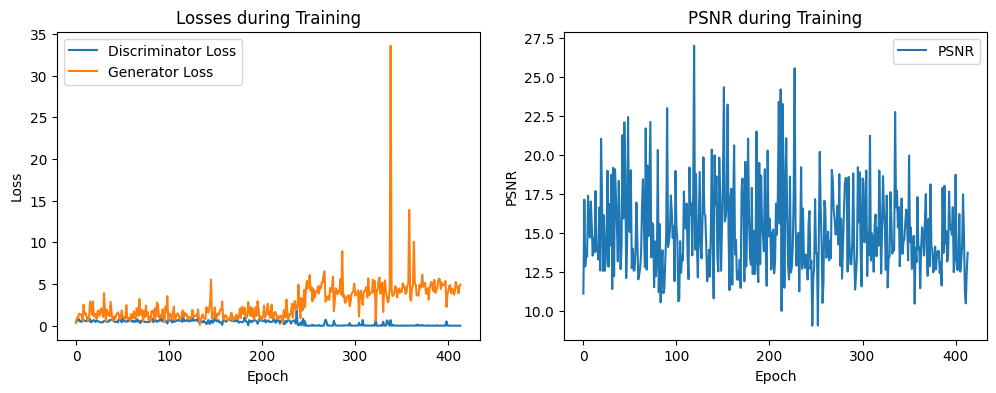

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.backends.mps.is_available()
                      else "cpu")

print(f"Using device: {device}")
# 1. Dataset Preparation: Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, high_res_path, transform=None, scale_factor=4):

        self.high_res_images = self.load_images(high_res_path)
        self.transform = transform
        self.scale_factor = scale_factor

    def load_images(self, path):
        images = []
        for filename in os.listdir(path):
            if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                images.append(os.path.join(path, filename))
        return images

    def __len__(self):
        return len(self.high_res_images)

    def __getitem__(self, idx):
        high_res_img = Image.open(self.high_res_images[idx]).convert('RGB')


        low_res_img = high_res_img.resize(
            (high_res_img.width // self.scale_factor, high_res_img.height // self.scale_factor),
            Image.BICUBIC
        )

        if self.transform:
            high_res_img = self.transform(high_res_img)
            low_res_img = self.transform(low_res_img)

        return low_res_img, high_res_img


# 2. Transformations: Resize to fixed size, normalize, and add augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# 3. Generator Architecture
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Generator layers with Residual connections
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.residual_block = self.make_residual_block(64)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4)

        self.batch_norm = nn.BatchNorm2d(64)  # Batch Normalization

    def make_residual_block(self, channels):
        return nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        res = self.residual_block(x)
        x = self.conv3(res + x)
        return x


# 4. Discriminator Architecture
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Discriminator layers with Spectral Normalization
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        self.relu = nn.ReLU(inplace=True)

        # Fully connected layers
        self.fc1_input_size = self._get_fc_input_size()

        self.fc1 = nn.Linear(self.fc1_input_size, 1024)
        self.fc2 = nn.Linear(1024, 1)

    def _get_fc_input_size(self):
        dummy_input = torch.randn(1, 3, 256, 256)
        x = self.relu(self.conv1(dummy_input))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        return x.size(1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


# 5. Loss Functions: Content loss (L1 loss) and Adversarial loss (Binary Cross Entropy)
def content_loss(generated, target):
    return torch.mean(torch.abs(generated - target))

def adversarial_loss(discriminator_output, target_label):
    return nn.BCELoss()(discriminator_output, target_label)

# De-normalize function
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Reverse normalization ([-1, 1] -> [0, 1])
    tensor = tensor.clamp(0, 1)  # Ensure all values are in the range [0, 1]
    return tensor

# PSNR Calculation
def calculate_psnr(generated, target):
    mse = torch.mean((generated - target) ** 2)
    psnr = 10 * torch.log10(1 / mse)
    return psnr


# 6. Training Setup
high_res_path = 'content/skin_cancer_images/Dermatofibroma'

# Dataset and DataLoader
dataset = CustomImageDataset(high_res_path, transform, scale_factor=4)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training Loop
num_epochs = 414
output_dir = "enhanced_images_df"
os.makedirs(output_dir, exist_ok=True)

# Track losses and PSNR
d_losses = []
g_losses = []
psnr_values = []

for epoch in range(num_epochs):
    for i, (low_res, high_res) in enumerate(dataloader):
        low_res, high_res = low_res.to(device), high_res.to(device)

        real_labels = torch.ones(low_res.size(0), 1).to(device)
        fake_labels = torch.zeros(low_res.size(0), 1).to(device)

        # Train Discriminator
        optimizer_d.zero_grad()

        real_output = discriminator(high_res)
        real_loss = adversarial_loss(real_output, real_labels)

        fake_high_res = generator(low_res)
        fake_output = discriminator(fake_high_res.detach())
        fake_loss = adversarial_loss(fake_output, fake_labels)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()

        fake_output = discriminator(fake_high_res)
        g_loss = adversarial_loss(fake_output, real_labels)

        c_loss = content_loss(fake_high_res, high_res)

        total_g_loss = g_loss + 0.1 * c_loss
        total_g_loss.backward()
        optimizer_g.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {total_g_loss.item():.4f}")

    # Save images and calculate PSNR at each epoch
    with torch.no_grad():
        low_res_sample = low_res[0].unsqueeze(0)
        enhanced_image = generator(low_res_sample.to(device))
        enhanced_image = enhanced_image.squeeze(0).cpu().detach()

        enhanced_image = denormalize(enhanced_image)
        high_res_image = denormalize(high_res[0]).cpu()

        psnr = calculate_psnr(enhanced_image, high_res_image)
        psnr_values.append(psnr.item())
        d_losses.append(d_loss.item())
        g_losses.append(total_g_loss.item())

        enhanced_image_np = (enhanced_image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

        output_path = os.path.join(output_dir, f'enhanced_epoch_{epoch+1}.png')
        plt.imsave(output_path, enhanced_image_np)

# Plot loss and PSNR graphs
plt.figure(figsize=(12, 4))

# Plot D Loss and G Loss
plt.subplot(1, 2, 1)
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Losses during Training')

# Plot PSNR
plt.subplot(1, 2, 2)
plt.plot(psnr_values, label="PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()
plt.title('PSNR during Training')

plt.show()


Using device: mps
Epoch [1/269], Step [1/21], D Loss: 0.6938, G Loss: 0.3693
Epoch [2/269], Step [1/21], D Loss: 0.8944, G Loss: 1.1019
Epoch [3/269], Step [1/21], D Loss: 0.1650, G Loss: 2.8730
Epoch [4/269], Step [1/21], D Loss: 0.6303, G Loss: 0.9135
Epoch [5/269], Step [1/21], D Loss: 0.6621, G Loss: 1.4457
Epoch [6/269], Step [1/21], D Loss: 0.3658, G Loss: 2.1924
Epoch [7/269], Step [1/21], D Loss: 0.5880, G Loss: 1.0774
Epoch [8/269], Step [1/21], D Loss: 0.4364, G Loss: 1.7217
Epoch [9/269], Step [1/21], D Loss: 0.5391, G Loss: 1.2471
Epoch [10/269], Step [1/21], D Loss: 0.5704, G Loss: 0.7613
Epoch [11/269], Step [1/21], D Loss: 0.5014, G Loss: 1.0547
Epoch [12/269], Step [1/21], D Loss: 0.4614, G Loss: 2.6433
Epoch [13/269], Step [1/21], D Loss: 0.8292, G Loss: 0.5423
Epoch [14/269], Step [1/21], D Loss: 0.4777, G Loss: 1.4235
Epoch [15/269], Step [1/21], D Loss: 0.5470, G Loss: 1.3430
Epoch [16/269], Step [1/21], D Loss: 0.3906, G Loss: 1.5871
Epoch [17/269], Step [1/21], D 

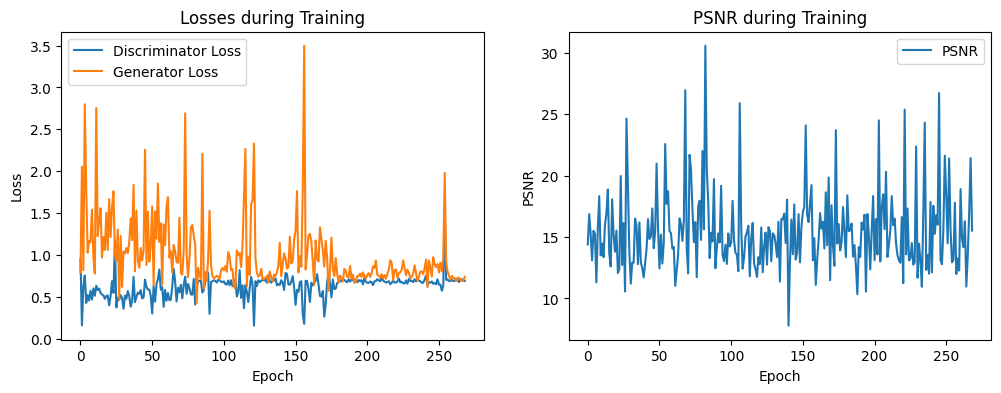

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.backends.mps.is_available()
                      else "cpu")

print(f"Using device: {device}")
# 1. Dataset Preparation: Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, high_res_path, transform=None, scale_factor=4):

        self.high_res_images = self.load_images(high_res_path)
        self.transform = transform
        self.scale_factor = scale_factor

    def load_images(self, path):
        images = []
        for filename in os.listdir(path):
            if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                images.append(os.path.join(path, filename))
        return images

    def __len__(self):
        return len(self.high_res_images)

    def __getitem__(self, idx):
        high_res_img = Image.open(self.high_res_images[idx]).convert('RGB')


        low_res_img = high_res_img.resize(
            (high_res_img.width // self.scale_factor, high_res_img.height // self.scale_factor),
            Image.BICUBIC
        )

        if self.transform:
            high_res_img = self.transform(high_res_img)
            low_res_img = self.transform(low_res_img)

        return low_res_img, high_res_img


# 2. Transformations: Resize to fixed size, normalize, and add augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# 3. Generator Architecture
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Generator layers with Residual connections
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.residual_block = self.make_residual_block(64)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4)

        self.batch_norm = nn.BatchNorm2d(64)  # Batch Normalization

    def make_residual_block(self, channels):
        return nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        res = self.residual_block(x)
        x = self.conv3(res + x)
        return x


# 4. Discriminator Architecture
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Discriminator layers with Spectral Normalization
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        self.relu = nn.ReLU(inplace=True)

        # Fully connected layers
        self.fc1_input_size = self._get_fc_input_size()

        self.fc1 = nn.Linear(self.fc1_input_size, 1024)
        self.fc2 = nn.Linear(1024, 1)

    def _get_fc_input_size(self):
        dummy_input = torch.randn(1, 3, 256, 256)
        x = self.relu(self.conv1(dummy_input))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        return x.size(1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


# 5. Loss Functions: Content loss (L1 loss) and Adversarial loss (Binary Cross Entropy)
def content_loss(generated, target):
    return torch.mean(torch.abs(generated - target))

def adversarial_loss(discriminator_output, target_label):
    return nn.BCELoss()(discriminator_output, target_label)

# De-normalize function
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Reverse normalization ([-1, 1] -> [0, 1])
    tensor = tensor.clamp(0, 1)  # Ensure all values are in the range [0, 1]
    return tensor

# PSNR Calculation
def calculate_psnr(generated, target):
    mse = torch.mean((generated - target) ** 2)
    psnr = 10 * torch.log10(1 / mse)
    return psnr


# 6. Training Setup
high_res_path = 'content/skin_cancer_images/AK'

# Dataset and DataLoader
dataset = CustomImageDataset(high_res_path, transform, scale_factor=4)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training Loop
num_epochs = 269
output_dir = "enhanced_images_AK"
os.makedirs(output_dir, exist_ok=True)

# Track losses and PSNR
d_losses = []
g_losses = []
psnr_values = []

for epoch in range(num_epochs):
    for i, (low_res, high_res) in enumerate(dataloader):
        low_res, high_res = low_res.to(device), high_res.to(device)

        real_labels = torch.ones(low_res.size(0), 1).to(device)
        fake_labels = torch.zeros(low_res.size(0), 1).to(device)

        # Train Discriminator
        optimizer_d.zero_grad()

        real_output = discriminator(high_res)
        real_loss = adversarial_loss(real_output, real_labels)

        fake_high_res = generator(low_res)
        fake_output = discriminator(fake_high_res.detach())
        fake_loss = adversarial_loss(fake_output, fake_labels)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()

        fake_output = discriminator(fake_high_res)
        g_loss = adversarial_loss(fake_output, real_labels)

        c_loss = content_loss(fake_high_res, high_res)

        total_g_loss = g_loss + 0.1 * c_loss
        total_g_loss.backward()
        optimizer_g.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {total_g_loss.item():.4f}")

    # Save images and calculate PSNR at each epoch
    with torch.no_grad():
        low_res_sample = low_res[0].unsqueeze(0)
        enhanced_image = generator(low_res_sample.to(device))
        enhanced_image = enhanced_image.squeeze(0).cpu().detach()

        enhanced_image = denormalize(enhanced_image)
        high_res_image = denormalize(high_res[0]).cpu()

        psnr = calculate_psnr(enhanced_image, high_res_image)
        psnr_values.append(psnr.item())
        d_losses.append(d_loss.item())
        g_losses.append(total_g_loss.item())

        enhanced_image_np = (enhanced_image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

        output_path = os.path.join(output_dir, f'enhanced_epoch_{epoch+1}.png')
        plt.imsave(output_path, enhanced_image_np)

# Plot loss and PSNR graphs
plt.figure(figsize=(12, 4))

# Plot D Loss and G Loss
plt.subplot(1, 2, 1)
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Losses during Training')

# Plot PSNR
plt.subplot(1, 2, 2)
plt.plot(psnr_values, label="PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()
plt.title('PSNR during Training')

plt.show()


Using device: mps
Epoch [1/414], Step [1/9], D Loss: 0.6934, G Loss: 0.6319
Epoch [2/414], Step [1/9], D Loss: 0.4458, G Loss: 3.1114
Epoch [3/414], Step [1/9], D Loss: 0.6681, G Loss: 1.0771
Epoch [4/414], Step [1/9], D Loss: 0.7845, G Loss: 1.0005
Epoch [5/414], Step [1/9], D Loss: 0.4571, G Loss: 2.0111
Epoch [6/414], Step [1/9], D Loss: 0.3803, G Loss: 5.4764
Epoch [7/414], Step [1/9], D Loss: 0.5878, G Loss: 0.6699
Epoch [8/414], Step [1/9], D Loss: 0.4989, G Loss: 1.1183
Epoch [9/414], Step [1/9], D Loss: 0.5022, G Loss: 1.4517
Epoch [10/414], Step [1/9], D Loss: 0.6789, G Loss: 0.6846
Epoch [11/414], Step [1/9], D Loss: 0.4901, G Loss: 2.1348
Epoch [12/414], Step [1/9], D Loss: 0.8043, G Loss: 2.3316
Epoch [13/414], Step [1/9], D Loss: 0.2460, G Loss: 1.6102
Epoch [14/414], Step [1/9], D Loss: 0.1965, G Loss: 2.6327
Epoch [15/414], Step [1/9], D Loss: 0.5442, G Loss: 1.3136
Epoch [16/414], Step [1/9], D Loss: 0.4741, G Loss: 1.2796
Epoch [17/414], Step [1/9], D Loss: 0.4021, G L

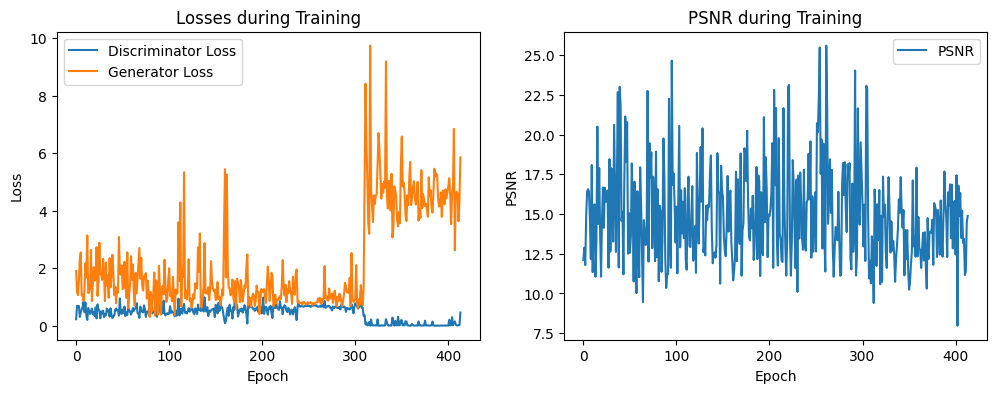

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.backends.mps.is_available()
                      else "cpu")

print(f"Using device: {device}")
# 1. Dataset Preparation: Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, high_res_path, transform=None, scale_factor=4):

        self.high_res_images = self.load_images(high_res_path)
        self.transform = transform
        self.scale_factor = scale_factor

    def load_images(self, path):
        images = []
        for filename in os.listdir(path):
            if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                images.append(os.path.join(path, filename))
        return images

    def __len__(self):
        return len(self.high_res_images)

    def __getitem__(self, idx):
        high_res_img = Image.open(self.high_res_images[idx]).convert('RGB')


        low_res_img = high_res_img.resize(
            (high_res_img.width // self.scale_factor, high_res_img.height // self.scale_factor),
            Image.BICUBIC
        )

        if self.transform:
            high_res_img = self.transform(high_res_img)
            low_res_img = self.transform(low_res_img)

        return low_res_img, high_res_img


# 2. Transformations: Resize to fixed size, normalize, and add augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# 3. Generator Architecture
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Generator layers with Residual connections
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.residual_block = self.make_residual_block(64)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4)

        self.batch_norm = nn.BatchNorm2d(64)  # Batch Normalization

    def make_residual_block(self, channels):
        return nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        res = self.residual_block(x)
        x = self.conv3(res + x)
        return x


# 4. Discriminator Architecture
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Discriminator layers with Spectral Normalization
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        self.relu = nn.ReLU(inplace=True)

        # Fully connected layers
        self.fc1_input_size = self._get_fc_input_size()

        self.fc1 = nn.Linear(self.fc1_input_size, 1024)
        self.fc2 = nn.Linear(1024, 1)

    def _get_fc_input_size(self):
        dummy_input = torch.randn(1, 3, 256, 256)
        x = self.relu(self.conv1(dummy_input))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        return x.size(1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


# 5. Loss Functions: Content loss (L1 loss) and Adversarial loss (Binary Cross Entropy)
def content_loss(generated, target):
    return torch.mean(torch.abs(generated - target))

def adversarial_loss(discriminator_output, target_label):
    return nn.BCELoss()(discriminator_output, target_label)

# De-normalize function
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Reverse normalization ([-1, 1] -> [0, 1])
    tensor = tensor.clamp(0, 1)  # Ensure all values are in the range [0, 1]
    return tensor

# PSNR Calculation
def calculate_psnr(generated, target):
    mse = torch.mean((generated - target) ** 2)
    psnr = 10 * torch.log10(1 / mse)
    return psnr


# 6. Training Setup
high_res_path = 'content/skin_cancer_images/VC'

# Dataset and DataLoader
dataset = CustomImageDataset(high_res_path, transform, scale_factor=4)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training Loop
num_epochs = 414
output_dir = "enhanced_images_VC"
os.makedirs(output_dir, exist_ok=True)

# Track losses and PSNR
d_losses = []
g_losses = []
psnr_values = []

for epoch in range(num_epochs):
    for i, (low_res, high_res) in enumerate(dataloader):
        low_res, high_res = low_res.to(device), high_res.to(device)

        real_labels = torch.ones(low_res.size(0), 1).to(device)
        fake_labels = torch.zeros(low_res.size(0), 1).to(device)

        # Train Discriminator
        optimizer_d.zero_grad()

        real_output = discriminator(high_res)
        real_loss = adversarial_loss(real_output, real_labels)

        fake_high_res = generator(low_res)
        fake_output = discriminator(fake_high_res.detach())
        fake_loss = adversarial_loss(fake_output, fake_labels)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()

        fake_output = discriminator(fake_high_res)
        g_loss = adversarial_loss(fake_output, real_labels)

        c_loss = content_loss(fake_high_res, high_res)

        total_g_loss = g_loss + 0.1 * c_loss
        total_g_loss.backward()
        optimizer_g.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {total_g_loss.item():.4f}")

    # Save images and calculate PSNR at each epoch
    with torch.no_grad():
        low_res_sample = low_res[0].unsqueeze(0)
        enhanced_image = generator(low_res_sample.to(device))
        enhanced_image = enhanced_image.squeeze(0).cpu().detach()

        enhanced_image = denormalize(enhanced_image)
        high_res_image = denormalize(high_res[0]).cpu()

        psnr = calculate_psnr(enhanced_image, high_res_image)
        psnr_values.append(psnr.item())
        d_losses.append(d_loss.item())
        g_losses.append(total_g_loss.item())

        enhanced_image_np = (enhanced_image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

        output_path = os.path.join(output_dir, f'enhanced_epoch_{epoch+1}.png')
        plt.imsave(output_path, enhanced_image_np)

# Plot loss and PSNR graphs
plt.figure(figsize=(12, 4))

# Plot D Loss and G Loss
plt.subplot(1, 2, 1)
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Losses during Training')

# Plot PSNR
plt.subplot(1, 2, 2)
plt.plot(psnr_values, label="PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()
plt.title('PSNR during Training')

plt.show()
